In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
latent_dim = 16
epochs = 20
lr = 1e-3
save_dir = "./vae_checkpoints"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
transform = transforms.ToTensor()  
train_ds = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_ds  = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 230kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 4.26MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.4MB/s]


In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=16):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()  
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x_hat = self.decoder_fc(z)
        x_hat = x_hat.view(-1, 1, 28, 28)
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

In [5]:
model = VAE(latent_dim=latent_dim).to(device)

In [6]:
bce_loss = nn.BCELoss(reduction="sum")

In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    recon_x_flat = recon_x.view(recon_x.size(0), -1)
    x_flat = x.view(x.size(0), -1)
    BCE = bce_loss(recon_x_flat, x_flat)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD

In [8]:
optimizer = optim.Adam(model.parameters(), lr=lr)

In [9]:
train_losses = []
test_losses = []


In [ ]:
for epoch in range(1, epochs+1):
    model.train()
    train_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, bce, kld = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss, bce, kld = vae_loss(recon_batch, data, mu, logvar)
            test_loss += loss.item()
    avg_test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch:d} | Train loss: {avg_train_loss:.6f} | Test loss: {avg_test_loss:.6f}")

    if epoch % 5 == 0 or epoch == epochs:
        torch.save(model.state_dict(), os.path.join(save_dir, f"vae_epoch{epoch}.pth"))

Epoch 1 | Train loss: 239.181687 | Test loss: 241.502326
Epoch 2 | Train loss: 238.910037 | Test loss: 240.944568
Epoch 3 | Train loss: 238.665551 | Test loss: 241.240216
Epoch 4 | Train loss: 238.381867 | Test loss: 240.699672
Epoch 5 | Train loss: 238.216013 | Test loss: 240.464439
Epoch 6 | Train loss: 238.047892 | Test loss: 240.805149
Epoch 7 | Train loss: 237.935275 | Test loss: 240.213572
Epoch 8 | Train loss: 237.739776 | Test loss: 240.169876
Epoch 9 | Train loss: 237.581581 | Test loss: 240.044252
Epoch 10 | Train loss: 237.458587 | Test loss: 240.036298
Epoch 11 | Train loss: 237.351136 | Test loss: 239.769532
Epoch 12 | Train loss: 237.243540 | Test loss: 239.879447
Epoch 13 | Train loss: 237.119507 | Test loss: 240.041450
Epoch 14 | Train loss: 237.026201 | Test loss: 239.517739
Epoch 15 | Train loss: 236.941512 | Test loss: 239.428789
Epoch 16 | Train loss: 236.839497 | Test loss: 239.552787
Epoch 17 | Train loss: 236.751503 | Test loss: 239.423833
Epoch 18 | Train loss: 

In [12]:
torch.save(model.state_dict(), os.path.join(save_dir, "vae_final.pth"))

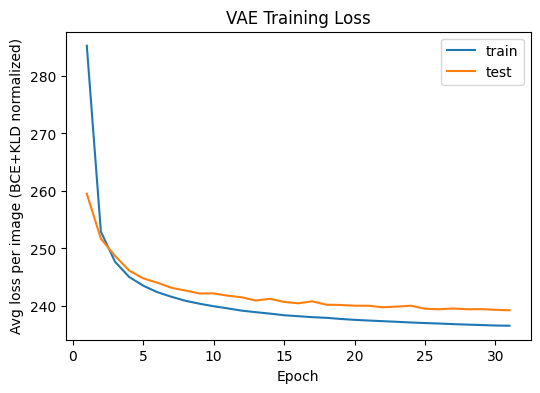

In [15]:
plt.figure(figsize=(6,4))
plt.plot(range(1, len(train_losses)+1), train_losses, label="train")
plt.plot(range(1, len(test_losses)+1), test_losses, label="test")
plt.xlabel("Epoch")
plt.ylabel("Avg loss per image (BCE+KLD normalized)")
plt.legend()
plt.title("VAE Training Loss")
plt.show()


In [16]:
model.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.to(device)[:16]
    recon, mu, logvar = model(data)

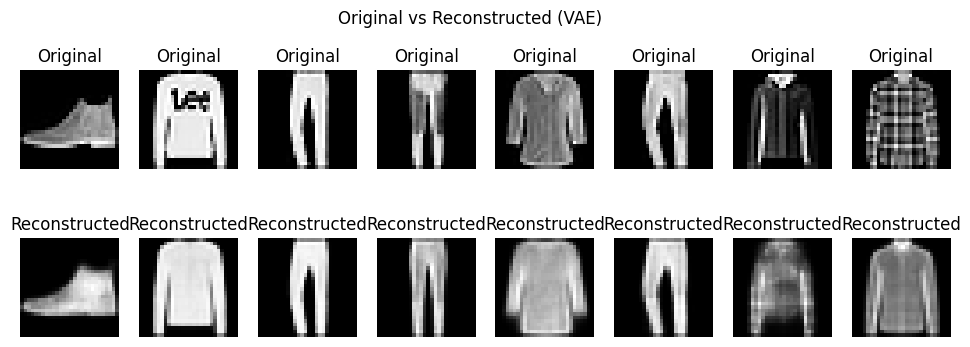

In [17]:
n = 8
plt.figure(figsize=(12,4))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(data[i].cpu().squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")
    plt.subplot(2, n, n+i+1)
    plt.imshow(recon[i].cpu().squeeze(), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")
plt.suptitle("Original vs Reconstructed (VAE)")
plt.show()

In [18]:
model.eval()
num_samples = 16
with torch.no_grad():
    z = torch.randn(num_samples, latent_dim).to(device)
    samples = model.decode(z).cpu()

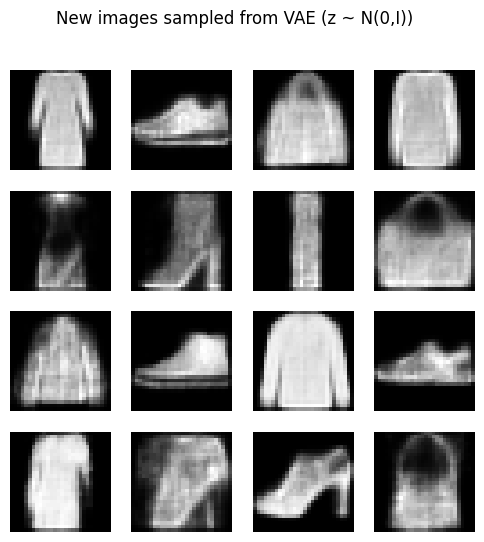

Done. Check saved models in: ./vae_checkpoints


In [19]:
plt.figure(figsize=(6,6))
for i in range(num_samples):
    plt.subplot(4, 4, i+1)
    plt.imshow(samples[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.suptitle("New images sampled from VAE (z ~ N(0,I))")
plt.show()

print("Done. Check saved models in:", save_dir)